# Benchmarck of statistical forecast models

This document compares the performance (mean absolute error and speed) of different statistical models compatible with `skforecast.ForecasterStats`:

- SARIMAX from `statsmodels`
- ARIMA from `aeon`
- ARAR from `skforecast`
- ETS from `aeon`

It also includes an autoregressive model from `skforecast` using Ridge model from `sklearn` as regressor for reference.

In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
path = str(Path.cwd().parent)
print(path)
sys.path.insert(1, path)

/home/joaquin/Documents/GitHub/skforecast


In [2]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import skforecast
from skforecast.sarimax import Sarimax
from skforecast.stats import Arar
from skforecast.experimental import ForecasterStats
from skforecast.experimental import backtesting_stats
from skforecast.model_selection import TimeSeriesFold, backtesting_forecaster
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from skforecast.recursive import ForecasterRecursive

from skforecast.plot import set_dark_theme
from skforecast.datasets import fetch_dataset
from aeon.forecasting.stats import ARIMA, ETS
import matplotlib.pyplot as plt
import timeit

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning, module="jupyter_client")
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")
print(f"skforecast version: {skforecast.__version__}")


skforecast version: 0.18.0


# Fuel consumption dataset

In [3]:
# Download data
# ==============================================================================
data = fetch_dataset(name='fuel_consumption', raw=True)
data = data[['Fecha', 'Gasolinas']]
data = data.rename(columns={'Fecha':'date', 'Gasolinas':'y'})
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.set_index('date')
data = data.asfreq('MS')
data = data.loc[:'1990-01-01 00:00:00', ['y']]
data['month'] = data.index.month
data = pd.get_dummies(data, columns=['month'], prefix='month', drop_first=False, dtype=float)
data

╭──────────────────────────────── fuel_consumption ────────────────────────────────╮
│ Description:                                                                     │
│ Monthly fuel consumption in Spain from 1969-01-01 to 2022-08-01.                 │
│                                                                                  │
│ Source:                                                                          │
│ Obtained from Corporación de Reservas Estratégicas de Productos Petrolíferos and │
│ Corporación de Derecho Público tutelada por el Ministerio para la Transición     │
│ Ecológica y el Reto Demográfico. https://www.cores.es/es/estadisticas            │
│                                                                                  │
│ URL:                                                                             │
│ https://raw.githubusercontent.com/skforecast/skforecast-                         │
│ datasets/main/data/consumos-combustibles-mensual.csv                             │
│                                                                                  │
│ Shape: 644 rows x 6 columns                                                      │
╰──────────────────────────────────────────────────────────────────────────────────╯

,y,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
date,,,,,,,,,,,,,
1969-01-01,166875.2129,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1969-02-01,155466.8105,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1969-03-01,184983.6699,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1969-04-01,202319.8164,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1969-05-01,206259.1523,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989-09-01,687649.2852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1989-10-01,669889.1602,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1989-11-01,601413.8867,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Train dates : 1969-01-01 00:00:00 --- 1980-01-01 00:00:00  (n=133)
Test dates  : 1980-02-01 00:00:00 --- 1990-01-01 00:00:00  (n=120)


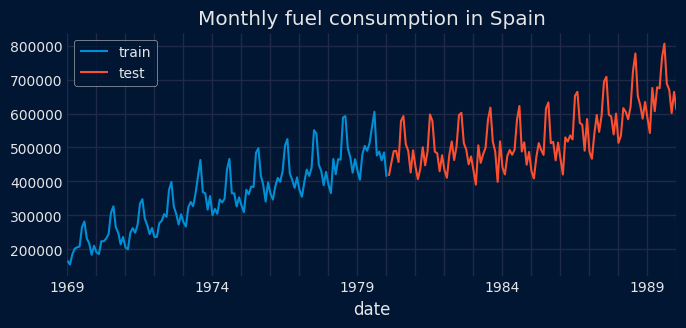

In [4]:
# Train-test dates
# ======================================================================================
set_dark_theme()
end_train = '1980-01-01 23:59:59'
print(
    f"Train dates : {data.index.min()} --- {data.loc[:end_train].index.max()}  "
    f"(n={len(data.loc[:end_train])})"
)
print(
    f"Test dates  : {data.loc[end_train:].index.min()} --- {data.loc[:].index.max()}  "
    f"(n={len(data.loc[end_train:])})"
)
data_train = data.loc[:end_train]
data_test  = data.loc[end_train:]

# Plot
# ======================================================================================
fig, ax=plt.subplots(figsize=(7, 3))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
ax.set_title('Monthly fuel consumption in Spain')
ax.legend();

In [5]:
# Backtesting ForecasterStats with sarimax statsmodels
# ==============================================================================
cv = TimeSeriesFold(
        steps              = 12,
        initial_train_size = len(data_train),
        refit              = True
)
forecaster = ForecasterStats(
                 regressor=Sarimax(order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), maxiter=500),
             )
start = timeit.default_timer()
metric_sarimax, pred_sarimax = backtesting_stats(
                    forecaster = forecaster,
                    y          = data['y'],
                    cv         = cv,
                    metric     = 'mean_absolute_error'
                )
stop = timeit.default_timer()
elapsed_time_sarimax = stop - start

  0%|          | 0/10 [00:00<?, ?it/s]

In [6]:
# Backtesting ForecasterStats with sarimax statsmodels with exogenous variables
# ==============================================================================
cv = TimeSeriesFold(
        steps              = 12,
        initial_train_size = len(data_train),
        refit              = True
)
forecaster = ForecasterStats(
                 regressor=Sarimax(order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), maxiter=500),
             )
start = timeit.default_timer()
metric_sarimax_exog, pred_sarimax_exog = backtesting_stats(
                    forecaster = forecaster,
                    y          = data['y'],
                    exog       = data.drop(columns='y'),
                    cv         = cv,
                    metric     = 'mean_absolute_error'
                )
stop = timeit.default_timer()
elapsed_time_sarimax_exog = stop - start

  0%|          | 0/10 [00:00<?, ?it/s]

In [7]:
# Backtesting ForecasterStats with ARIMA aeon
# ==============================================================================
cv = TimeSeriesFold(
        steps              = 12,
        initial_train_size = len(data_train),
        refit              = True
)
forecaster = ForecasterStats(
                 regressor=ARIMA(p=13, d=1, q=13, iterations=1000),
             )
start = timeit.default_timer()
metric_arima, pred_arima = backtesting_stats(
                    forecaster = forecaster,
                    y          = data['y'],
                    cv         = cv,
                    metric     = 'mean_absolute_error'
                )
stop = timeit.default_timer()
elapsed_time_arima = stop - start

  0%|          | 0/10 [00:00<?, ?it/s]

In [8]:
# Backtesting ForecasterStats with ARAR skforecast
# ==============================================================================
cv = TimeSeriesFold(
        steps              = 12,
        initial_train_size = len(data_train),
        refit              = True
)
forecaster = ForecasterStats(
                 regressor=Arar(max_ar_depth=10, max_lag=10)
             )
start = timeit.default_timer()
metric_arar, pred_arar = backtesting_stats(
                    forecaster = forecaster,
                    y          = data['y'],
                    cv         = cv,
                    metric     = 'mean_absolute_error'
                )
stop = timeit.default_timer()
elapsed_time_arar = stop - start

  0%|          | 0/10 [00:00<?, ?it/s]

In [9]:
# Backtesting ForecasterStats with ETS aeon
# ==============================================================================
cv = TimeSeriesFold(
        steps              = 12,
        initial_train_size = len(data_train),
        refit              = True,
        fixed_train_size   = False,
)
forecaster = ForecasterStats(
                 regressor=ETS(seasonal_period=12),
             )
start = timeit.default_timer()
metric_ets, pred_ets = backtesting_stats(
                    forecaster = forecaster,
                    y          = data['y'],
                    cv         = cv,
                    metric     = 'mean_absolute_error'
                )
stop = timeit.default_timer()
elapsed_time_ets = stop - start

  0%|          | 0/10 [00:00<?, ?it/s]

In [10]:
# Backtesting ForecasterStats with sklearn Ridge
# ==============================================================================
params = {'alpha': 0.001}
forecaster = ForecasterRecursive(
                 regressor     = Ridge(**params, random_state=123),
                 lags          = 12,
                 transformer_y = StandardScaler(),
             )
start = timeit.default_timer()
metric_ridge, predictions_ridge = backtesting_forecaster(
                          forecaster = forecaster,
                          y          = data['y'],
                          exog       = data.drop(columns=['y']),
                          cv         = cv,
                          metric     = 'mean_absolute_error'
                      )
stop = timeit.default_timer()
elapsed_time_ridge = stop - start

  0%|          | 0/10 [00:00<?, ?it/s]

In [11]:
# Results
# ==============================================================================
results = pd.DataFrame(
    {
        "Model": [
            "Sarimax",
            "Sarimax Exogenous",
            "ARIMA aeon",
            "ARAR skforecast",
            "ETS aeon",
            "Ridge sklearn",
        ],
        "MAE": [
            metric_sarimax.at[0, "mean_absolute_error"],
            metric_sarimax_exog.at[0, "mean_absolute_error"],
            metric_arima.at[0, "mean_absolute_error"],
            metric_arar.at[0, "mean_absolute_error"],
            metric_ets.at[0, "mean_absolute_error"],
            metric_ridge.at[0, "mean_absolute_error"],
        ],
        "Elapsed Time (s)": [
            elapsed_time_sarimax,
            elapsed_time_sarimax_exog,
            elapsed_time_arima,
            elapsed_time_arar,
            elapsed_time_ets,
            elapsed_time_ridge,
        ],
    }
)
results = results.sort_values(by="MAE").reset_index(drop=True)
results

,Model,MAE,Elapsed Time (s)
0,Sarimax Exogenous,20528.190756,75.879589
1,Sarimax,20528.190769,29.244164
2,Ridge sklearn,22846.649242,0.611227
3,ARAR skforecast,24211.988300,0.329128
4,ARIMA aeon,33398.995574,1.633026
5,ETS aeon,70773.251667,0.248790


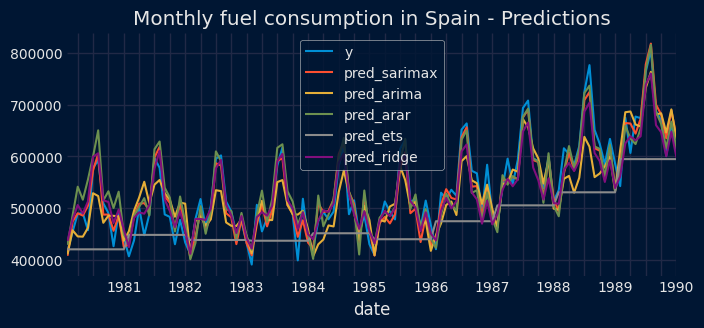

In [12]:
fig, ax = plt.subplots(figsize=(7, 3))
data['y'].loc[data_test.index].plot(ax=ax, label='y')
pred_sarimax['pred'].plot(ax=ax, label='pred_sarimax')
pred_arima['pred'].plot(ax=ax, label='pred_arima')
pred_arar['pred'].plot(ax=ax, label='pred_arar')
pred_ets['pred'].plot(ax=ax, label='pred_ets')
predictions_ridge['pred'].plot(ax=ax, label='pred_ridge')
ax.set_title('Monthly fuel consumption in Spain - Predictions')
ax.legend();

# Web traffic dataset

In [29]:
# Data downloading
# ==============================================================================
data = fetch_dataset(name="website_visits", raw=True, verbose=False)
data['date'] = pd.to_datetime(data['date'], format='%d/%m/%y')
data = data.set_index('date')
data = data.asfreq('1D')
data = data.sort_index()

In [30]:
# Features based on calendar
# ==============================================================================
data['month'] = data.index.month
data['month_day'] = data.index.day
data['week_day'] = data.index.day_of_week

# One hot encoding transformer
# ==============================================================================
one_hot_encoder = make_column_transformer(
    (
        OneHotEncoder(sparse_output=False, drop='if_binary'),
        ['month', 'week_day', 'month_day'],
    ),
    remainder="passthrough",
    verbose_feature_names_out=False,
).set_output(transform="pandas")

data = one_hot_encoder.fit_transform(data)
data.head(3)

,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,...,month_day_23,month_day_24,month_day_25,month_day_26,month_day_27,month_day_28,month_day_29,month_day_30,month_day_31,users
date,,,,,,,,,,,,,,,,,,,,,
2020-07-01,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2324
2020-07-02,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2201
2020-07-03,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2146


Training dates   : 2020-07-01 00:00:00 --- 2021-03-30 00:00:00  (n=273)
Test dates       : 2021-03-31 00:00:00 --- 2021-08-25 00:00:00  (n=148)


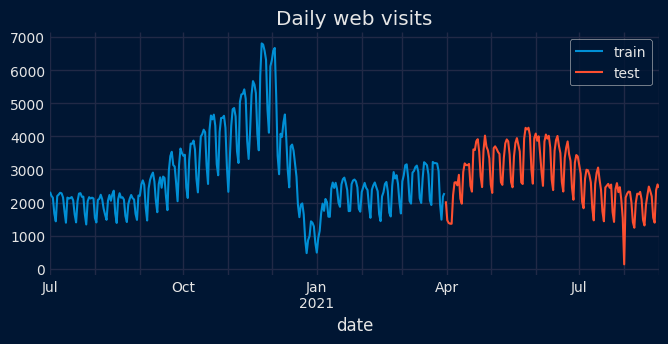

In [31]:
# Split data train-val-test
# ==============================================================================
end_train = '2021-03-30 23:59:00'
data_train = data.loc[: end_train, :]
data_test  = data.loc[end_train:, :]
exog_features = [col for col in data.columns if col.startswith(('month_', 'week_day_', 'month_day_'))]
print(f"Training dates   : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

# Plot
# ======================================================================================
fig, ax=plt.subplots(figsize=(7, 3))
data_train['users'].plot(ax=ax, label='train')
data_test['users'].plot(ax=ax, label='test')
ax.set_title('Daily web visits')
ax.legend();

In [32]:
# Backtesting ForecasterStats with ARAR skforecast
# ==============================================================================
cv = TimeSeriesFold(
        steps              = 7,
        initial_train_size = len(data.loc[:end_train]),
        refit              = True,
        fixed_train_size   = False,
      )
forecaster = ForecasterStats(
                 regressor=Arar(max_ar_depth=10, max_lag=10)
             )
start = timeit.default_timer()
metric_arar, pred_arar = backtesting_stats(
                    forecaster = forecaster,
                    y          = data['users'],
                    cv         = cv,
                    metric     = 'mean_absolute_error'
                )
stop = timeit.default_timer()
elapsed_time_arar = stop - start

  0%|          | 0/22 [00:00<?, ?it/s]

In [33]:
# Backtesting ForecasterStats with sklearn Ridge
# ==============================================================================
params = {'alpha': np.float64(2.154434690031882)}
forecaster = ForecasterRecursive(
                 regressor     = Ridge(**params, random_state=123),
                 lags          = 14,
                 transformer_y = StandardScaler(),
                 forecaster_id = 'web_traffic'
             )
start = timeit.default_timer()
metric_ridge, predictions_ridge = backtesting_forecaster(
                          forecaster = forecaster,
                          y          = data['users'],
                          exog       = data[exog_features],
                          cv         = cv,
                          metric     = 'mean_absolute_error'
                      )
stop = timeit.default_timer()
elapsed_time_ridge = stop - start

  0%|          | 0/22 [00:00<?, ?it/s]

In [34]:
# Backtesting ForecasterStats with sarimax statsmodels
# ==============================================================================
forecaster = ForecasterStats(
                 regressor=Sarimax(order=(2, 1, 1), seasonal_order=(1, 1, 1, 7), maxiter=500),
             )
start = timeit.default_timer()
metric_sarimax, pred_sarimax = backtesting_stats(
                    forecaster = forecaster,
                    y          = data['users'],
                    cv         = cv,
                    metric     = 'mean_absolute_error'
                )
stop = timeit.default_timer()
elapsed_time_sarimax = stop - start

  0%|          | 0/22 [00:00<?, ?it/s]

In [35]:
# Backtesting ForecasterStats with sarimax statsmodels with exogenous variables
# ==============================================================================
# forecaster = ForecasterStats(
#                  regressor=Sarimax(order=(2, 1, 1), seasonal_order=(1, 1, 1, 7), maxiter=500),
#              )
# start = timeit.default_timer()
# metric_sarimax_exog, pred_sarimax_exog = backtesting_stats(
#                     forecaster = forecaster,
#                     y          = data['users'],
#                     exog       = data.drop(columns='users'),
#                     cv         = cv,
#                     metric     = 'mean_absolute_error'
#                 )
# stop = timeit.default_timer()
# elapsed_time_sarimax_exog = stop - start

In [36]:
results = pd.DataFrame(
    {
        "Model": [
            "ARAR skforecast",
            "sklearn Ridge",
            "SARIMAX statsmodels",
            #"SARIMAX statsmodels Exogenous",
        ],
        "MAE": [
            metric_arar.at[0, "mean_absolute_error"],
            metric_ridge.at[0, "mean_absolute_error"],
            metric_sarimax.at[0, "mean_absolute_error"],
            #metric_sarimax_exog.at[0, "mean_absolute_error"],
        ],
        "Elapsed Time (s)": [
            elapsed_time_arar,
            elapsed_time_ridge,
            elapsed_time_sarimax,
            #elapsed_time_sarimax_exog,
        ],
    }
)
results = results.sort_values(by="MAE").reset_index(drop=True)
results

,Model,MAE,Elapsed Time (s)
0,sklearn Ridge,180.156629,0.729181
1,SARIMAX statsmodels,217.206636,61.688306
2,ARAR skforecast,238.186705,0.219515


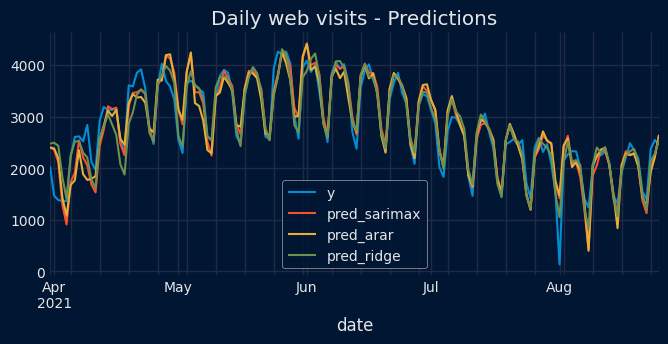

In [37]:
fig, ax = plt.subplots(figsize=(7, 3))
data['users'].loc[data_test.index].plot(ax=ax, label='y')
pred_sarimax['pred'].plot(ax=ax, label='pred_sarimax')
pred_arar['pred'].plot(ax=ax, label='pred_arar')
predictions_ridge['pred'].plot(ax=ax, label='pred_ridge')
ax.set_title('Daily web visits - Predictions')
ax.legend();